In [77]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd



In [24]:
class EllipticCurve(object):
   def __init__(self, a, b):
      # assume we're already in the Weierstrass form
      self.a = a
      self.b = b

      self.discriminant = -16 * (4 * a*a*a + 27 * b * b)
      if not self.isSmooth():
         raise Exception("The curve %s is not smooth!" % self)


   def isSmooth(self):
      return self.discriminant != 0


   def testPoint(self, x, y):
      return y*y == x*x*x + self.a * x + self.b


   def __str__(self):
      return 'y^2 = x^3 + %sx + %s' % (self.a, self.b)


   def __repr__(self):
      return str(self)


   def __eq__(self, other):
      return (self.a, self.b) == (other.a, other.b)



class Point(object):
   def __init__(self, curve, x, y):
      self.curve = curve # the curve containing this point
      self.x = x
      self.y = y

      #if not curve.testPoint(x,y):
      #   raise Exception("The point %s is not on the given curve %s!" % (self, curve))


   def __str__(self):
      return "(%r, %r)" % (self.x, self.y)


   def __repr__(self):
      return str(self)


   def __neg__(self):
      return Point(self.curve, self.x, -self.y)


   def __add__(self, Q):
      if self.curve != Q.curve:
         raise Exception("Can't add points on different curves!")
      if isinstance(Q, Ideal):
         return self

      x_1, y_1, x_2, y_2 = self.x, self.y, Q.x, Q.y

      if (x_1, y_1) == (x_2, y_2):
         if y_1 == 0:
            return Ideal(self.curve)

         # slope of the tangent line
         m = (3 * x_1 * x_1 + self.curve.a) / (2 * y_1)
      else:
         if x_1 == x_2:
            return Ideal(self.curve)

         # slope of the secant line
         m = (y_2 - y_1) / (x_2 - x_1)

      x_3 = m*m - x_2 - x_1
      y_3 = m*(x_3 - x_1) + y_1

      return Point(self.curve, x_3, -y_3)


   def __sub__(self, Q):
      return self + -Q

   def __mul__(self, n):
      if not isinstance(n, int):
         raise Exception("Can't scale a point by something which isn't an int!")

      if n < 0:
         return -self * -n

      if n == 0:
         return Ideal(self.curve)

      Q = self
      R = self if n & 1 == 1 else Ideal(self.curve)

      i = 2
      while i <= n:
         Q += Q
         if n & i == i:
             R += Q
         i = i << 1
      return R


   def __rmul__(self, n):
      return self * n

   def __list__(self):
      return [self.x, self.y]

   def __eq__(self, other):
      if type(other) is Ideal:
         return False

      return self.x, self.y == other.x, other.y

   def __ne__(self, other):
      return not self == other

   def __getitem__(self, index):
      return [self.x, self.y][index]


class Ideal(Point):
   def __init__(self, curve):
      self.curve = curve

   def __neg__(self):
      return self

   def __str__(self):
      return "Ideal"

   def __add__(self, Q):
      if self.curve != Q.curve:
         raise Exception("Can't add points on different curves!")
      return Q

   def __mul__(self, n):
      if not isinstance(n, int):
         raise Exception("Can't scale a point by something which isn't an int!")
      else:
         return self

   def __eq__(self, other):
      return type(other) is Ideal

In [25]:
C = EllipticCurve(a=frac(-2), b=frac(4))
P = Point(C, frac(3), frac(5))
Q = Point(C, frac(-2), frac(0))
zero = Ideal(C)


In [26]:
float(Q.x)

-2.0

In [29]:
def generate_walk_on_eliptic_curve(n):
    walk = [];
    C = EllipticCurve(a=-2, b=4)
    P = Point(C, 3, 5)

    walk.append((float(P.x), float(P.y)))
    
    
    for i in range(n):
        P = P + P
        walk.append((float(P.x), float(P.y)))
        
    return walk

        

In [75]:
walk_on_eleptic_curve = np.array(generate_walk_on_eliptic_curve(100000))
walk_on_eleptic_curve.tofile("walk", "\n")

In [65]:
def embed_data(x, h, tau, m):
    offset = round(tau / h)
    return np.array([x[i * offset:-(m-i)*offset] for i in range(m)]).T

In [96]:
embeded_walk = embed_data(walk_on_eleptic_curve[:, 0], 1, 10, 10)


(0, 20)

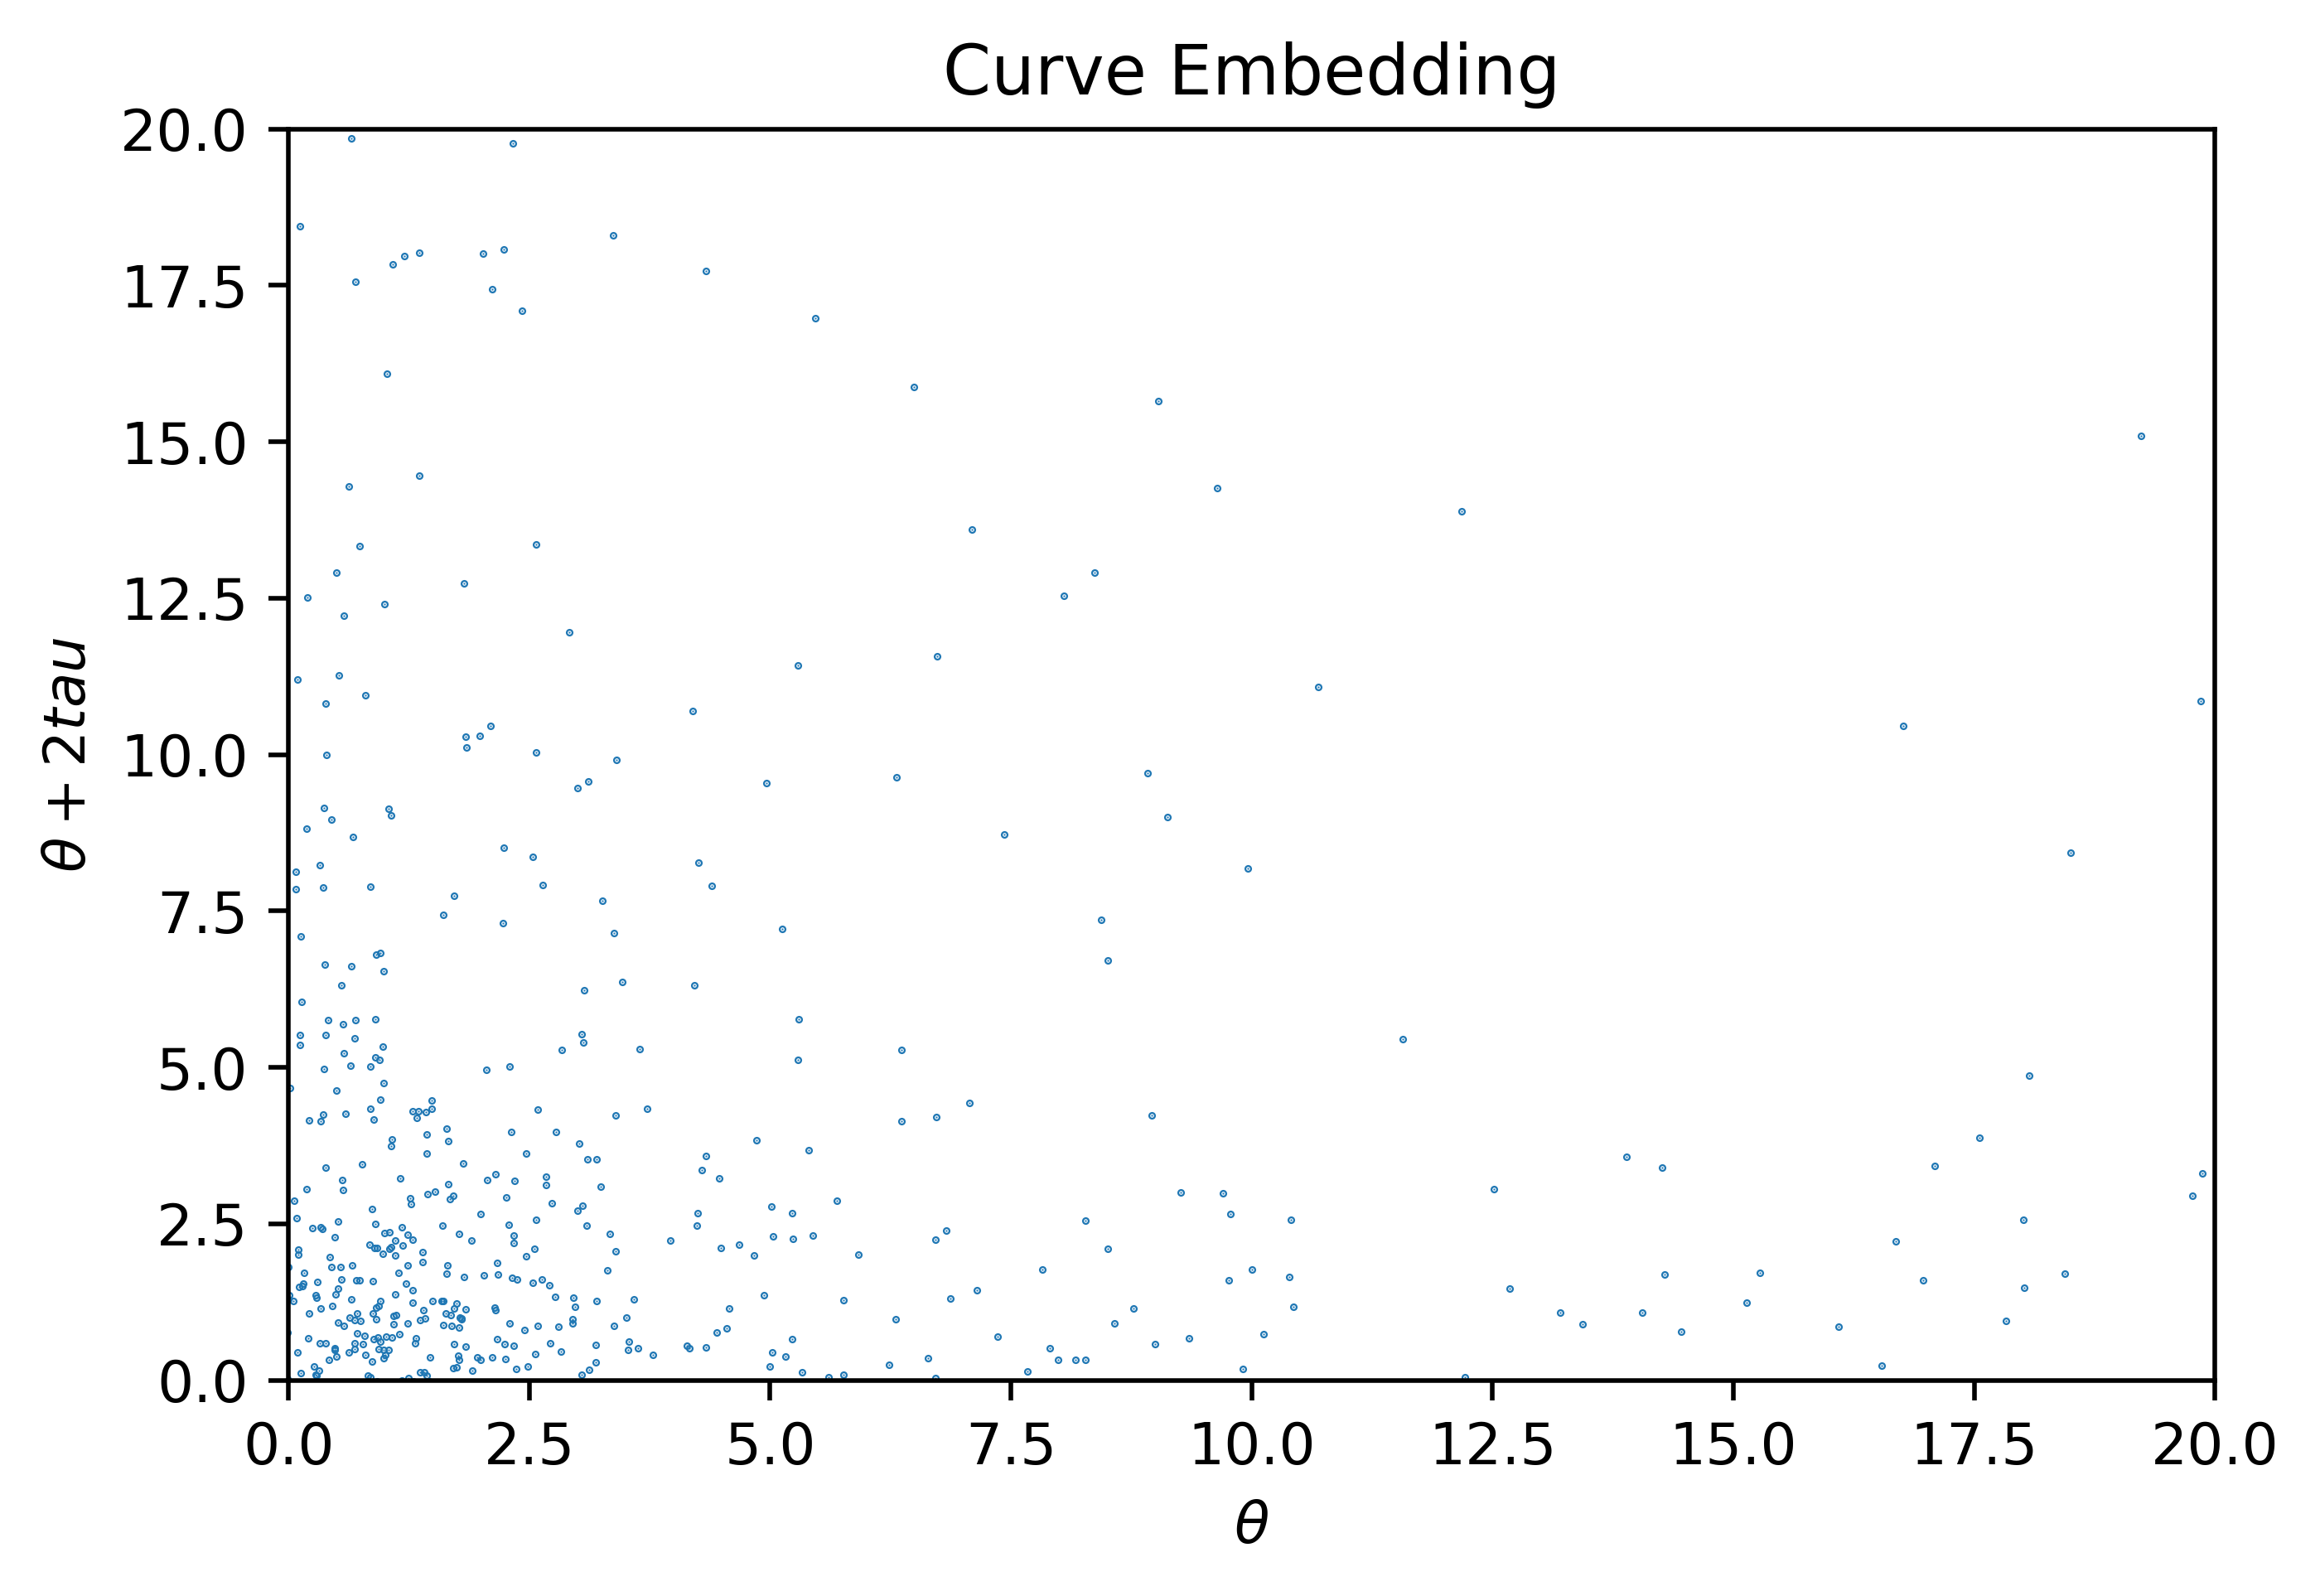

In [98]:
fig1 = plt.figure(dpi=500)
ax = fig1.add_subplot(1,1,1)
ax.scatter(embeded_walk[:,0], embeded_walk[:,2], s=0.1)
#ax.set_xlim(np.pi - 0.2, 1*np.pi + 0.1)
ax.set_title("Curve Embedding")
ax.set_xlabel("$\\theta$")
ax.set_ylabel("$\\theta + 2 tau$")
ax.set_xlim(0, 20)
ax.set_ylim(0,20)

In [86]:
dfwalk = pd.read_csv('walk_information_shared', sep='\s+', header=None)
walk_information_shared = np.array(dfwalk)


Text(0, 0.5, 'Information Shared')

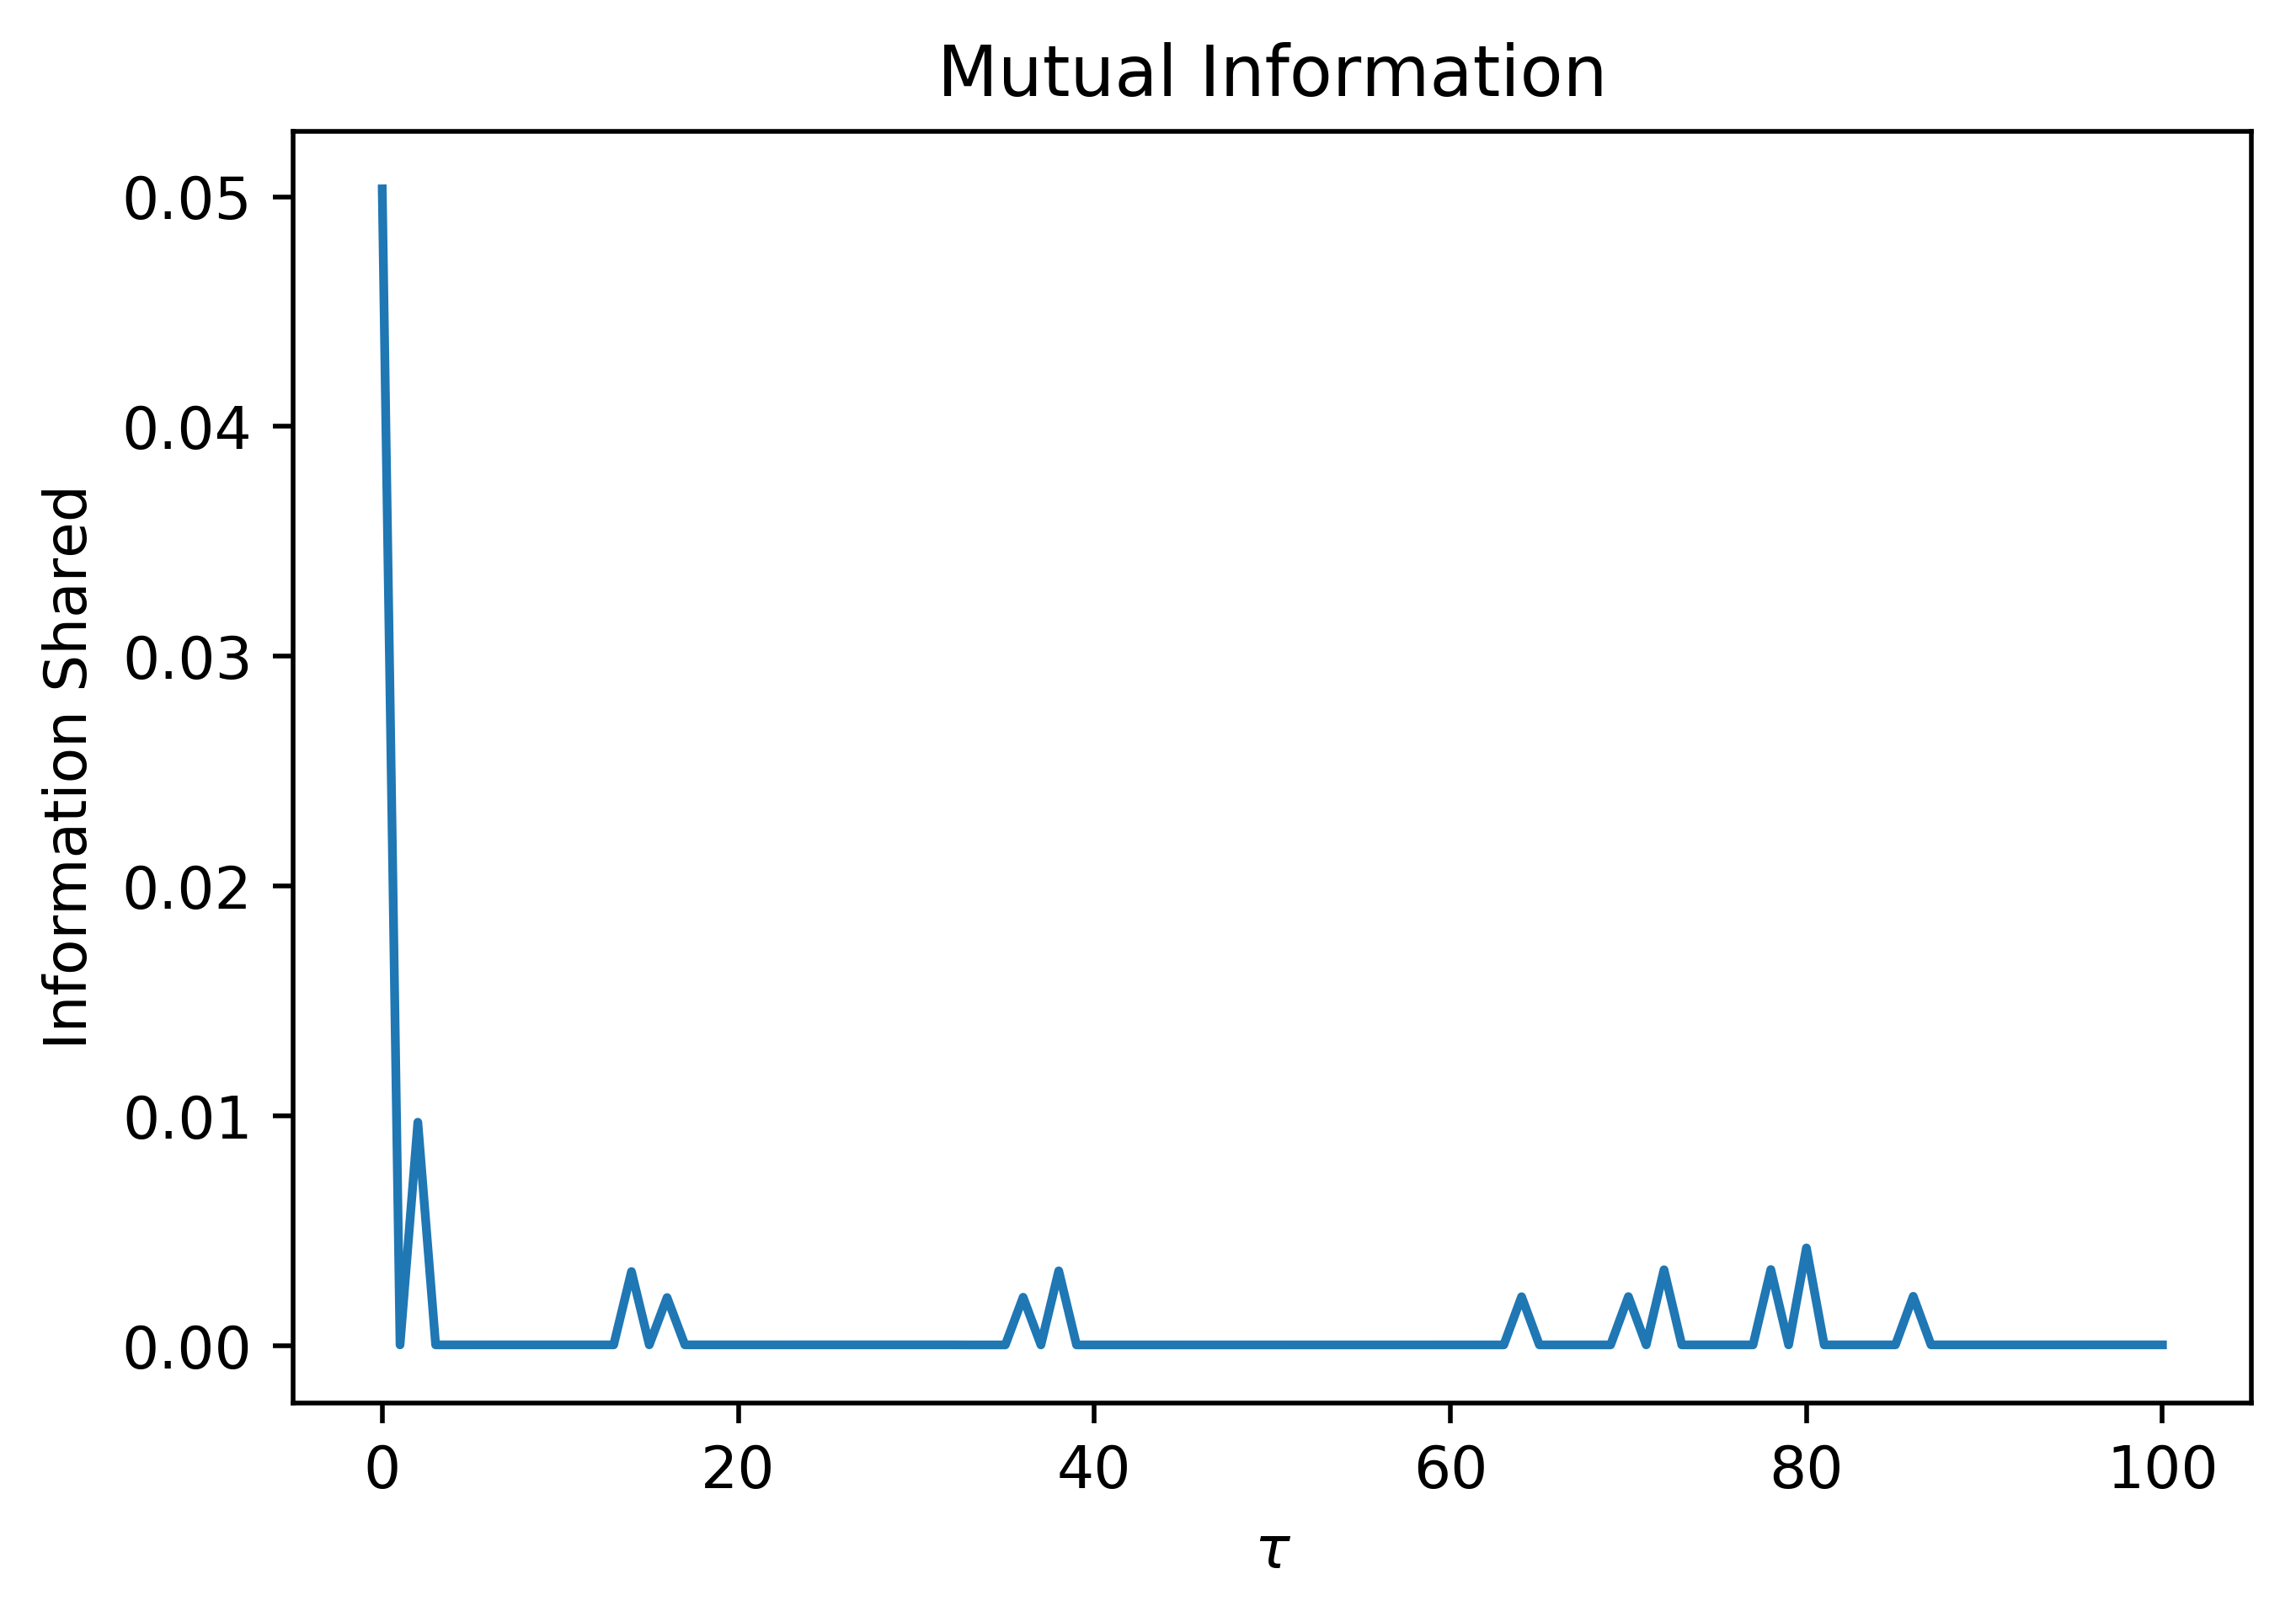

In [87]:
fig1 = plt.figure(dpi=500)
ax = fig1.add_subplot(1,1,1)
ax.plot(walk_information_shared[:,0], walk_information_shared[:,1])
#ax.set_xlim(np.pi - 0.2, 1*np.pi + 0.1)
ax.set_title("Mutual Information")
ax.set_xlabel("$\\tau$")
ax.set_ylabel("Information Shared")

In [92]:
walk_fnndf = pd.read_csv('walk_fnn', sep='\s+', header=None)
walk_fnn = np.array(walk_fnndf)


Text(0, 0.5, 'FNN %')

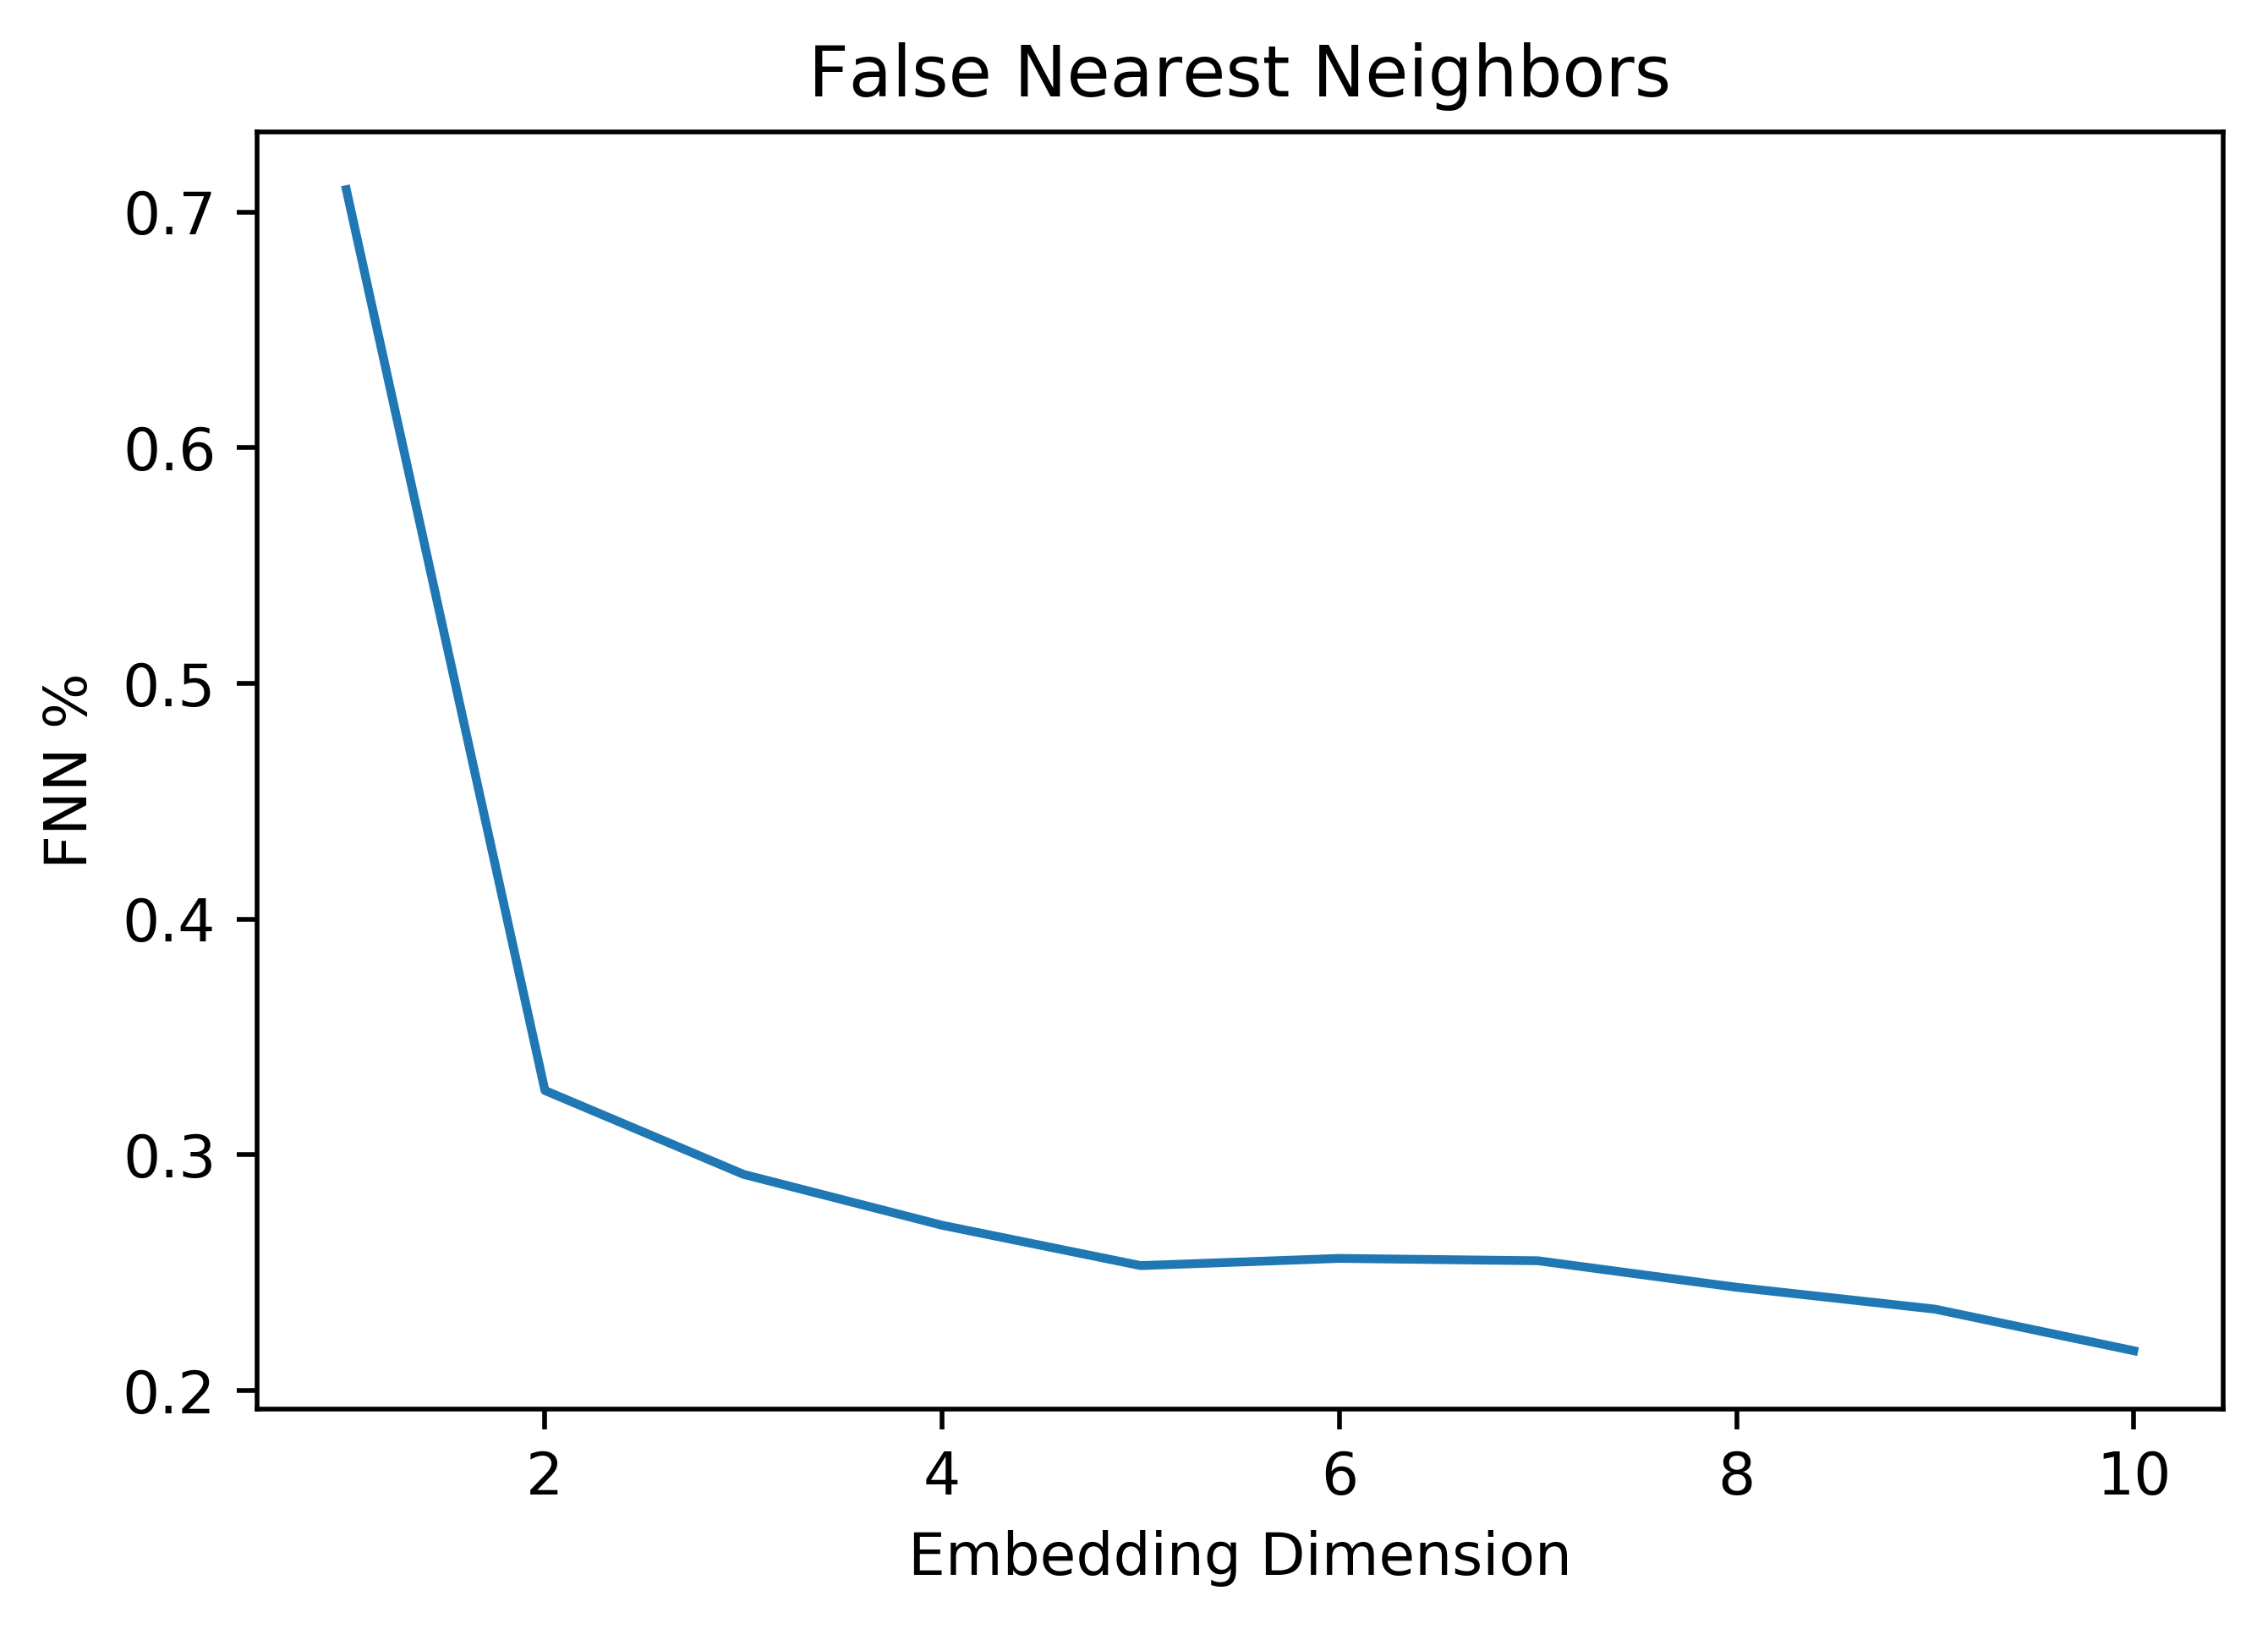

In [93]:
fig1 = plt.figure(dpi=500)
ax = fig1.add_subplot(1,1,1)
ax.plot(walk_fnn[:,0], walk_fnn[:,1])
#ax.set_xlim(np.pi - 0.2, 1*np.pi + 0.1)
ax.set_title("False Nearest Neighbors")
ax.set_xlabel("Embedding Dimension")
ax.set_ylabel("FNN %")
